## Deliverable 3: Optimize the Model

Up to this point, the accuracy from the existing model has an accuracy of 72.56%. The goal is to increase accuracy above 75%. From the initial file, the following changes have already been made prior to the application_df file:
- Application Type has been binned to group all application types with under 200 value counts
- Classification has been binned to group all classifications with under 1000 value counts
- Categorical data has been encoded with OneHotEncoder

One observation: there are 8747 unique values in the Ask Amount column, which are likely posing a major problem, for the neural networks since it doesn't interpret the numbers as sequential, but rather as just unique values. This column should either be removed or binned into groups. 

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from pathlib import Path
import kerastuner as kt

#  Import and read the charity_data.csv.
application_df = pd.read_csv("Resources/application_df.csv")
application_df.head()


c:\Users\justi\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  if __name__ == '__main__':


,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [2]:
ask_counts = application_df.ASK_AMT.value_counts()
ask_counts

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

Just binning by frequency poses a problem because aside from $5000, most others asked for individualized amounts, so ranges will need to be made

In [3]:
min_ask = application_df.ASK_AMT.min()
max_ask = application_df.ASK_AMT.max()
median_ask = application_df.ASK_AMT.median()

print(f'Min: {min_ask}, Median: {median_ask}, Max: {max_ask}')

Min: 5000, Median: 5000.0, Max: 8597806340


The data is heavily skewed to the right with values ranging from $5000 to $8.6 billion.  The following steps were used to determine good amounts to get similarly sized bins for effective learning outside of the '5000' bin

In [4]:
five_thousand = application_df.ASK_AMT[application_df.ASK_AMT == 5000]
five_thousand.value_counts()

5000    25398
Name: ASK_AMT, dtype: int64

In [5]:
under_thirtyfive = application_df.ASK_AMT[(application_df.ASK_AMT > 5000) & (application_df.ASK_AMT < 35000)]
under_thirtyfive.nunique()


2185

In [6]:
under_hundred = application_df.ASK_AMT[(application_df.ASK_AMT > 35000) & (application_df.ASK_AMT < 100000)]
under_hundred.nunique()


2044

In [7]:
under_fivehundred = application_df.ASK_AMT[(
    application_df.ASK_AMT > 100000) & (application_df.ASK_AMT < 500000)]
under_fivehundred.nunique()


2289

In [8]:

over_halfmillion = application_df.ASK_AMT[application_df.ASK_AMT > 500000]
over_halfmillion.nunique()


2226

In [9]:
# Apply the bins, labeling with the arbitrary 1-5 categories for the network learning
bins = [0, 5000, 35000, 100000, 500000, max_ask]
labels = [1, 2, 3, 4, 5]

application_df["ASK_BIN"] = pd.cut(application_df["ASK_AMT"], bins=bins, labels=labels)


In [10]:
application_df[["ASK_AMT","ASK_BIN"]].head(10)

,ASK_AMT,ASK_BIN
0,5000,1
1,108590,4
2,5000,1
3,6692,2
4,142590,4
5,5000,1
6,31452,2
7,7508025,5
8,94389,3
9,5000,1


In [11]:
# Verify the same value counts as planned - if true, then remove the ASK_AMT column 
application_df["ASK_BIN"].value_counts()

1    25398
4     2304
2     2283
5     2227
3     2087
Name: ASK_BIN, dtype: int64

In [12]:
application_df = application_df.drop(columns="ASK_AMT")
application_df.head()

,STATUS,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_BIN
0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
2,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
4,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4


In [13]:
# Check the number of unique values in all of the parameters to ensure they are all under 10
application_df.nunique()

# all are n=2 except the ASK_BIN which is now 5, substantially less than the 8747 it started with

STATUS                          2
IS_SUCCESSFUL                   2
APPLICATION_TYPE_Other          2
APPLICATION_TYPE_T10            2
APPLICATION_TYPE_T19            2
APPLICATION_TYPE_T3             2
APPLICATION_TYPE_T4             2
APPLICATION_TYPE_T5             2
APPLICATION_TYPE_T6             2
APPLICATION_TYPE_T7             2
APPLICATION_TYPE_T8             2
AFFILIATION_CompanySponsored    2
AFFILIATION_Family/Parent       2
AFFILIATION_Independent         2
AFFILIATION_National            2
AFFILIATION_Other               2
AFFILIATION_Regional            2
CLASSIFICATION_C1000            2
CLASSIFICATION_C1200            2
CLASSIFICATION_C2000            2
CLASSIFICATION_C2100            2
CLASSIFICATION_C3000            2
CLASSIFICATION_Other            2
USE_CASE_CommunityServ          2
USE_CASE_Heathcare              2
USE_CASE_Other                  2
USE_CASE_Preservation           2
USE_CASE_ProductDev             2
ORGANIZATION_Association        2
ORGANIZATION_C

<AxesSubplot:ylabel='Density'>

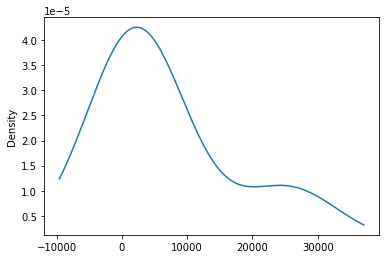

In [14]:
ask_bin_counts = application_df.ASK_BIN.value_counts()
ask_bin_counts.plot.density()

In [15]:
# The Special Considerations columns are redundant and one should be dropped
application_df = application_df.drop(columns="SPECIAL_CONSIDERATIONS_N")


## Separate Sets and Training



In [16]:
def df_trainer(df):
    # Remove the outcome and set up the training model
    y = df.IS_SUCCESSFUL
    X = df.drop(columns="IS_SUCCESSFUL")

    # Split the preprocessed data into a training and testing dataset, values are not balanced - apply stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=512, stratify=y)

    # Scale the data
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


In [17]:
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(application_df)


### Using the same model as the original analysis after basketing the ask amounts

In [18]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_layer1 = 80
hidden_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer1,
       input_dim=number_input_features, activation='relu'))

# Second hidden layer

nn.add(tf.keras.layers.Dense(units=hidden_layer2, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                3440      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 5,901
Trainable params: 5,901
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Define Checkpoint Path and filenames
os.makedirs("checkpoints_2/", exist_ok=True)
checkpoint_path = "checkpoints_2/weights.{epoch:02d}.hdf5"


In [20]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5
)


In [21]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=5, callbacks=[cp_callback])


Epoch 1/5
  1/804 [..............................] - ETA: 5:23 - loss: 0.7571 - accuracy: 0.3750
Epoch 1: saving model to checkpoints_2\weights.01.hdf5

Epoch 1: saving model to checkpoints_2\weights.01.hdf5

Epoch 1: saving model to checkpoints_2\weights.01.hdf5
 15/804 [..............................] - ETA: 2s - loss: 0.6976 - accuracy: 0.5000  
Epoch 1: saving model to checkpoints_2\weights.01.hdf5

Epoch 1: saving model to checkpoints_2\weights.01.hdf5

Epoch 1: saving model to checkpoints_2\weights.01.hdf5

Epoch 1: saving model to checkpoints_2\weights.01.hdf5
 35/804 [>.............................] - ETA: 2s - loss: 0.6636 - accuracy: 0.6116
Epoch 1: saving model to checkpoints_2\weights.01.hdf5

Epoch 1: saving model to checkpoints_2\weights.01.hdf5

Epoch 1: saving model to checkpoints_2\weights.01.hdf5

Epoch 1: saving model to checkpoints_2\weights.01.hdf5
 55/804 [=>............................] - ETA: 2s - loss: 0.6388 - accuracy: 0.6534
Epoch 1: saving model to checkpoi

In [22]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


268/268 - 0s - loss: 0.5598 - accuracy: 0.7240 - 247ms/epoch - 922us/step
Loss: 0.559778094291687, Accuracy: 0.7239649891853333


The code achieved the near 73% accuracy in 5 epochs for proof of concept. Next will test with the keras-tuner

In [23]:
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation', ['relu', 'tanh', 'exponential', 'softmax'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
                                                    min_value=1,
                                                    max_value=100,
                                                    step=5),
                                       activation=activation,
                                       input_dim=len(X_train_scaled[0])))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
      nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                      min_value=1,
                                                      max_value=100,
                                                      step=5),
                                         activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy",
                     optimizer='adam', metrics=["accuracy"])

    return nn_model


In [24]:


tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)


In [25]:
# Run the tuner search for the best hyperparameters
tuner.search(X_train_scaled, y_train, epochs=5,
             validation_data=(X_test_scaled, y_test))


Trial 16 Complete [00h 00m 04s]
val_accuracy: 0.726064145565033

Best val_accuracy So Far: 0.7266472578048706
Total elapsed time: 00h 01m 01s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
softmax           |relu              |activation
26                |86                |first_units
2                 |2                 |num_layers
11                |56                |units_0
61                |61                |units_1
31                |1                 |units_2
91                |56                |units_3
61                |96                |units_4
5                 |5                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
1                 |0                 |tuner/bracket
1                 |0                 |tuner/round
0012              |None              |tuner/trial_id

Epoch 3/5
207/804 [======>.......................] - ETA: 0s - loss: 0.6920 - accuracy: 0.5290

KeyboardInterrupt: 

In [ ]:
top_hyper=tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'relu', 'first_units': 56, 'num_layers': 3, 'units_0': 56, 'units_1': 36, 'units_2': 26, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0002'}
{'activation': 'relu', 'first_units': 36, 'num_layers': 2, 'units_0': 51, 'units_1': 41, 'units_2': 66, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'softmax', 'first_units': 36, 'num_layers': 3, 'units_0': 6, 'units_1': 21, 'units_2': 46, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [ ]:
# Evaluate the top 3 against the test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


268/268 - 0s - loss: 0.5564 - accuracy: 0.7278 - 332ms/epoch - 1ms/step
Loss: 0.5564, Accuracy: 0.7278
268/268 - 0s - loss: 0.5591 - accuracy: 0.7264 - 313ms/epoch - 1ms/step
Loss: 0.5591, Accuracy: 0.7264
268/268 - 0s - loss: 0.5805 - accuracy: 0.7262 - 363ms/epoch - 1ms/step
Loss: 0.5805, Accuracy: 0.7262


At this point, none of the tuned models have exceeded 73%, so further data cleaning will be necessary to optimize the model. 
The different parameters are:
Application Type
Affiliation
Classification
Use Case
Organization
Status
Income Amount
Special Consideration
Ask Amount

Instead of doing a top down approach, and continuing to remove variables from the existing group, I'm going to try a bottom up approach and add back variables from a base set of the most superficial parameters to the more technical. 

Affiliation, Organization, and Use Case could be a very easy way to filter out applicants if the predictive ability is high.  


In [ ]:
optimizer_df = application_df[[
    'IS_SUCCESSFUL',
    'AFFILIATION_CompanySponsored', 
    'AFFILIATION_Family/Parent', 
    'AFFILIATION_Independent', 
    'AFFILIATION_National', 
    'AFFILIATION_Other', 
    'AFFILIATION_Regional',
    'USE_CASE_CommunityServ',
    'USE_CASE_Heathcare',
    'USE_CASE_Other',
    'USE_CASE_Preservation',
    'USE_CASE_ProductDev',
    'ORGANIZATION_Association',
    'ORGANIZATION_Co-operative',
    'ORGANIZATION_Corporation',
    'ORGANIZATION_Trust']]
optimizer_df.head()

,IS_SUCCESSFUL,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust
0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Separate and scale parameters in the df
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

In [ ]:
# Tune with the same parameters as the previous model
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)
tuner.search(X_train_scaled, y_train, epochs=10, validation_data=(X_test_scaled, y_test))


Trial 20 Complete [00h 00m 06s]
val_accuracy: 0.6928279995918274

Best val_accuracy So Far: 0.6928279995918274
Total elapsed time: 00h 01m 22s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


268/268 - 0s - loss: 0.6135 - accuracy: 0.6928 - 323ms/epoch - 1ms/step
Loss: 0.6135, Accuracy: 0.6928
268/268 - 0s - loss: 0.6111 - accuracy: 0.6926 - 335ms/epoch - 1ms/step
Loss: 0.6111, Accuracy: 0.6926
268/268 - 0s - loss: 0.6484 - accuracy: 0.6924 - 343ms/epoch - 1ms/step
Loss: 0.6484, Accuracy: 0.6924


In [ ]:
# These parameters alone had a reduced accuracy of 69.2%.  Adding income to the next set. 
additional_columns = [
    'INCOME_AMT_0',
    'INCOME_AMT_1-9999',
    'INCOME_AMT_10000-24999',
    'INCOME_AMT_100000-499999',
    'INCOME_AMT_10M-50M',
    'INCOME_AMT_1M-5M',
    'INCOME_AMT_25000-99999',
    'INCOME_AMT_50M+',
    'INCOME_AMT_5M-10M']
 
optimizer_df[additional_columns] = application_df[additional_columns]

c:\Users\justi\anaconda3\envs\mlenv\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
optimizer_df.head()

,IS_SUCCESSFUL,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Run tuner again with the additional income variables
# Separate and scale parameters in the df
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=5, validation_data=(X_test_scaled, y_test))


Trial 20 Complete [00h 00m 07s]
val_accuracy: 0.6956267952919006

Best val_accuracy So Far: 0.697842538356781
Total elapsed time: 00h 01m 23s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


# This increase the accuracy to 69.8%

268/268 - 0s - loss: 0.6100 - accuracy: 0.6978 - 313ms/epoch - 1ms/step
Loss: 0.6100, Accuracy: 0.6978
268/268 - 0s - loss: 0.6102 - accuracy: 0.6977 - 331ms/epoch - 1ms/step
Loss: 0.6102, Accuracy: 0.6977
268/268 - 0s - loss: 0.6077 - accuracy: 0.6975 - 326ms/epoch - 1ms/step
Loss: 0.6077, Accuracy: 0.6975


In [ ]:
# Add in the application type
additional_columns = [
    'APPLICATION_TYPE_Other',
    'APPLICATION_TYPE_T10',
    'APPLICATION_TYPE_T19',
    'APPLICATION_TYPE_T3',
    'APPLICATION_TYPE_T4',
    'APPLICATION_TYPE_T5',
    'APPLICATION_TYPE_T6',
    'APPLICATION_TYPE_T7',
    'APPLICATION_TYPE_T8']

optimizer_df[additional_columns] = application_df[additional_columns]
optimizer_df.head()


c:\Users\justi\anaconda3\envs\mlenv\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,IS_SUCCESSFUL,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,...,INCOME_AMT_5M-10M,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8
0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Run tuner again with the application type
# Separate and scale parameters in the df
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=5,
             validation_data=(X_test_scaled, y_test))


Trial 20 Complete [00h 00m 06s]
val_accuracy: 0.7213994264602661

Best val_accuracy So Far: 0.723498523235321
Total elapsed time: 00h 01m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Adding the application type brought the model back up to 72.3%


268/268 - 0s - loss: 0.5770 - accuracy: 0.7235 - 348ms/epoch - 1ms/step
Loss: 0.5770, Accuracy: 0.7235
268/268 - 0s - loss: 0.5800 - accuracy: 0.7226 - 333ms/epoch - 1ms/step
Loss: 0.5800, Accuracy: 0.7226
268/268 - 0s - loss: 0.5823 - accuracy: 0.7224 - 320ms/epoch - 1ms/step
Loss: 0.5823, Accuracy: 0.7224


In [ ]:
additional_columns = [
    'CLASSIFICATION_C1000'    ,
    'CLASSIFICATION_C1200'   ,
    'CLASSIFICATION_C2000'  ,
    'CLASSIFICATION_C2100' ,
    'CLASSIFICATION_C3000',
    'CLASSIFICATION_Other']

optimizer_df[additional_columns] = application_df[additional_columns]
optimizer_df.head()


c:\Users\justi\anaconda3\envs\mlenv\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,IS_SUCCESSFUL,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,...,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other
0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Run tuner again with the classification
# Separate and scale parameters in the df
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=5,
             validation_data=(X_test_scaled, y_test))
 


Trial 20 Complete [00h 00m 06s]
val_accuracy: 0.7245481014251709

Best val_accuracy So Far: 0.7268804907798767
Total elapsed time: 00h 01m 22s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# the classification marginally increased the accuracy to 72.7%


268/268 - 0s - loss: 0.5638 - accuracy: 0.7269 - 341ms/epoch - 1ms/step
Loss: 0.5638, Accuracy: 0.7269
268/268 - 0s - loss: 0.5597 - accuracy: 0.7262 - 362ms/epoch - 1ms/step
Loss: 0.5597, Accuracy: 0.7262
268/268 - 0s - loss: 0.5612 - accuracy: 0.7262 - 310ms/epoch - 1ms/step
Loss: 0.5612, Accuracy: 0.7262


In [ ]:
optimizer_df["ASK_BIN"] = application_df["ASK_BIN"]

In [ ]:
# Run tuner again with the asking amount binned into 5 categories, at this point, the only category missing is the special considerations
# Separate and scale parameters in the df
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=5,
             validation_data=(X_test_scaled, y_test))


Trial 20 Complete [00h 00m 06s]
val_accuracy: 0.7266472578048706

Best val_accuracy So Far: 0.727580189704895
Total elapsed time: 00h 01m 23s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# the asking amounts didn't change the accuracy


268/268 - 0s - loss: 0.5813 - accuracy: 0.7276 - 315ms/epoch - 1ms/step
Loss: 0.5813, Accuracy: 0.7276
268/268 - 0s - loss: 0.5558 - accuracy: 0.7269 - 381ms/epoch - 1ms/step
Loss: 0.5558, Accuracy: 0.7269
268/268 - 0s - loss: 0.5815 - accuracy: 0.7268 - 307ms/epoch - 1ms/step
Loss: 0.5815, Accuracy: 0.7268


## Since the bottom up starting with the superficial parameters, we'll now remove those parameters with a top-down removal from the original df


In [ ]:
columns = ['AFFILIATION_CompanySponsored',
           'AFFILIATION_Family/Parent',
           'AFFILIATION_Independent',
           'AFFILIATION_National',
           'AFFILIATION_Other',
           'AFFILIATION_Regional']

optimizer_df = application_df.drop(columns=columns)

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=5,
             validation_data=(X_test_scaled, y_test))


Trial 20 Complete [00h 00m 07s]
val_accuracy: 0.6474635601043701

Best val_accuracy So Far: 0.6492128372192383
Total elapsed time: 00h 01m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Removing affiliation drastically reduced the accuracy 


268/268 - 0s - loss: 0.6173 - accuracy: 0.6492 - 334ms/epoch - 1ms/step
Loss: 0.6173, Accuracy: 0.6492
268/268 - 0s - loss: 0.6174 - accuracy: 0.6484 - 338ms/epoch - 1ms/step
Loss: 0.6174, Accuracy: 0.6484
268/268 - 0s - loss: 0.6185 - accuracy: 0.6484 - 336ms/epoch - 1ms/step
Loss: 0.6185, Accuracy: 0.6484


In [ ]:
# Trying by removing Use Case

columns = ['USE_CASE_CommunityServ',
           'USE_CASE_Heathcare',
           'USE_CASE_Other',
           'USE_CASE_Preservation',
           'USE_CASE_ProductDev']

optimizer_df = application_df.drop(columns=columns)


In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=5,
             validation_data=(X_test_scaled, y_test))


Trial 20 Complete [00h 00m 07s]
val_accuracy: 0.726064145565033

Best val_accuracy So Far: 0.7278134226799011
Total elapsed time: 00h 01m 27s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Removing Use Case had no effect


268/268 - 0s - loss: 0.5763 - accuracy: 0.7278 - 322ms/epoch - 1ms/step
Loss: 0.5763, Accuracy: 0.7278
268/268 - 0s - loss: 0.5750 - accuracy: 0.7270 - 340ms/epoch - 1ms/step
Loss: 0.5750, Accuracy: 0.7270
268/268 - 0s - loss: 0.5613 - accuracy: 0.7268 - 314ms/epoch - 1ms/step
Loss: 0.5613, Accuracy: 0.7268


In [ ]:
optimizer_df.head()

,STATUS,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_Y,ASK_BIN
0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
# Remove organization in addition to the Use Case
columns = [
    'ORGANIZATION_Association',
    'ORGANIZATION_Co-operative',
    'ORGANIZATION_Corporation',
    'ORGANIZATION_Trust']
optimizer_df = optimizer_df.drop(columns=columns)

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=5,
             validation_data=(X_test_scaled, y_test))

top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Removing the organization reduced the accuracy

Trial 20 Complete [00h 00m 07s]
val_accuracy: 0.4676384925842285

Best val_accuracy So Far: 0.72116619348526
Total elapsed time: 00h 01m 27s
INFO:tensorflow:Oracle triggered exit
268/268 - 0s - loss: 0.5840 - accuracy: 0.7212 - 300ms/epoch - 1ms/step
Loss: 0.5840, Accuracy: 0.7212
268/268 - 0s - loss: 0.5864 - accuracy: 0.7209 - 305ms/epoch - 1ms/step
Loss: 0.5864, Accuracy: 0.7209
268/268 - 0s - loss: 0.5728 - accuracy: 0.7201 - 322ms/epoch - 1ms/step
Loss: 0.5728, Accuracy: 0.7201


In [ ]:
columns = ['USE_CASE_CommunityServ',
           'USE_CASE_Heathcare',
           'USE_CASE_Other',
           'USE_CASE_Preservation',
           'USE_CASE_ProductDev', 
           'ASK_BIN']

optimizer_df = application_df.drop(columns=columns)


In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=5,
             validation_data=(X_test_scaled, y_test))



Trial 20 Complete [00h 00m 06s]
val_accuracy: 0.7262973785400391

Best val_accuracy So Far: 0.7267638444900513
Total elapsed time: 00h 01m 26s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Accuracy is improved by removing the ask bins

268/268 - 0s - loss: 0.5766 - accuracy: 0.7268 - 304ms/epoch - 1ms/step
Loss: 0.5766, Accuracy: 0.7268
268/268 - 0s - loss: 0.5624 - accuracy: 0.7266 - 337ms/epoch - 1ms/step
Loss: 0.5624, Accuracy: 0.7266
268/268 - 0s - loss: 0.5803 - accuracy: 0.7266 - 322ms/epoch - 1ms/step
Loss: 0.5803, Accuracy: 0.7266


In [ ]:
columns = ['USE_CASE_CommunityServ',
           'USE_CASE_Heathcare',
           'USE_CASE_Other',
           'USE_CASE_Preservation',
           'USE_CASE_ProductDev',
           'ASK_BIN', 
           'SPECIAL_CONSIDERATIONS_Y']

optimizer_df = application_df.drop(columns=columns)
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=5,
             validation_data=(X_test_scaled, y_test))


Trial 20 Complete [00h 00m 06s]
val_accuracy: 0.7262973785400391

Best val_accuracy So Far: 0.7266472578048706
Total elapsed time: 00h 01m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Accuracy is slightly reduced with removal of the special considerations


268/268 - 0s - loss: 0.5750 - accuracy: 0.7266 - 307ms/epoch - 1ms/step
Loss: 0.5750, Accuracy: 0.7266
268/268 - 0s - loss: 0.5782 - accuracy: 0.7265 - 338ms/epoch - 1ms/step
Loss: 0.5782, Accuracy: 0.7265
268/268 - 0s - loss: 0.5809 - accuracy: 0.7265 - 417ms/epoch - 2ms/step
Loss: 0.5809, Accuracy: 0.7265


In [ ]:
columns = ['USE_CASE_CommunityServ',
           'USE_CASE_Heathcare',
           'USE_CASE_Other',
           'USE_CASE_Preservation',
           'USE_CASE_ProductDev',
           'ASK_BIN',
           'STATUS']

optimizer_df = application_df.drop(columns=columns)
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=5,
             validation_data=(X_test_scaled, y_test))


Trial 20 Complete [00h 00m 07s]
val_accuracy: 0.7261807322502136

Best val_accuracy So Far: 0.7262973785400391
Total elapsed time: 00h 01m 27s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Accuracy is slightly reduced with removal of status


268/268 - 0s - loss: 0.5766 - accuracy: 0.7263 - 309ms/epoch - 1ms/step
Loss: 0.5766, Accuracy: 0.7263
268/268 - 0s - loss: 0.5820 - accuracy: 0.7262 - 346ms/epoch - 1ms/step
Loss: 0.5820, Accuracy: 0.7262
268/268 - 0s - loss: 0.5685 - accuracy: 0.7259 - 303ms/epoch - 1ms/step
Loss: 0.5685, Accuracy: 0.7259


In [ ]:
columns = ['USE_CASE_CommunityServ',
           'USE_CASE_Heathcare',
           'USE_CASE_Other',
           'USE_CASE_Preservation',
           'USE_CASE_ProductDev', 
           'ASK_BIN',
           'INCOME_AMT_0',
           'INCOME_AMT_1-9999',
           'INCOME_AMT_10000-24999',
           'INCOME_AMT_100000-499999',
           'INCOME_AMT_10M-50M',
           'INCOME_AMT_1M-5M',
           'INCOME_AMT_25000-99999',
           'INCOME_AMT_50M+',
           'INCOME_AMT_5M-10M']

optimizer_df = application_df.drop(columns=columns)
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=5,
             validation_data=(X_test_scaled, y_test))


Trial 20 Complete [00h 00m 06s]
val_accuracy: 0.4676384925842285

Best val_accuracy So Far: 0.7220991253852844
Total elapsed time: 00h 01m 28s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Accuracy is slightly reduced with removal of income - best so far has been removal of use-case and ask-bin


268/268 - 0s - loss: 0.5698 - accuracy: 0.7221 - 319ms/epoch - 1ms/step
Loss: 0.5698, Accuracy: 0.7221
268/268 - 0s - loss: 0.5688 - accuracy: 0.7219 - 324ms/epoch - 1ms/step
Loss: 0.5688, Accuracy: 0.7219
268/268 - 0s - loss: 0.5677 - accuracy: 0.7216 - 329ms/epoch - 1ms/step
Loss: 0.5677, Accuracy: 0.7216


In [ ]:
# Increased the function to increase hidden layer possibilities to 100 and layers to 5
columns = ['USE_CASE_CommunityServ',
           'USE_CASE_Heathcare',
           'USE_CASE_Other',
           'USE_CASE_Preservation',
           'USE_CASE_ProductDev',
           'ASK_BIN']

optimizer_df = application_df.drop(columns=columns)
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=5,
             validation_data=(X_test_scaled, y_test))


Trial 20 Complete [00h 00m 07s]
val_accuracy: 0.726064145565033

Best val_accuracy So Far: 0.727580189704895
Total elapsed time: 00h 01m 31s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')



268/268 - 0s - loss: 0.5635 - accuracy: 0.7276 - 324ms/epoch - 1ms/step
Loss: 0.5635, Accuracy: 0.7276
268/268 - 0s - loss: 0.5654 - accuracy: 0.7270 - 354ms/epoch - 1ms/step
Loss: 0.5654, Accuracy: 0.7270
268/268 - 0s - loss: 0.5662 - accuracy: 0.7263 - 332ms/epoch - 1ms/step
Loss: 0.5662, Accuracy: 0.7263


In [ ]:
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)


{'activation': 'tanh', 'first_units': 36, 'num_layers': 3, 'units_0': 21, 'units_1': 66, 'units_2': 91, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0003'}
{'activation': 'relu', 'first_units': 41, 'num_layers': 5, 'units_0': 56, 'units_1': 76, 'units_2': 36, 'units_3': 21, 'units_4': 36, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'tanh', 'first_units': 36, 'num_layers': 3, 'units_0': 21, 'units_1': 66, 'units_2': 91, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


# Going to test by increasing to 200 epochs now that the parameters are optimized

In [ ]:
# Increased the function to increase hidden layer possibilities to 100 and layers to 5
columns = ['USE_CASE_CommunityServ',
           'USE_CASE_Heathcare',
           'USE_CASE_Other',
           'USE_CASE_Preservation',
           'USE_CASE_ProductDev',
           'ASK_BIN']

optimizer_df = application_df.drop(columns=columns)
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=200,
    hyperband_iterations=2,
    overwrite=True)

tuner.search(X_train_scaled, y_train, epochs=0,
             validation_data=(X_test_scaled, y_test))


Trial 501 Complete [00h 02m 15s]
val_accuracy: 0.7267638444900513

Best val_accuracy So Far: 0.7280466556549072
Total elapsed time: 02h 40m 05s

Search: Running Trial #502

Value             |Best Value So Far |Hyperparameter
tanh              |relu              |activation
81                |21                |first_units
2                 |2                 |num_layers
31                |71                |units_0
66                |21                |units_1
76                |11                |units_2
51                |61                |units_3
46                |46                |units_4
200               |67                |tuner/epochs
67                |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
1                 |0                 |tuner/round
0493              |None              |tuner/trial_id

Epoch 68/200
511/804 [==================>...........] - ETA: 0s - loss: 0.5731 - accuracy: 0.7236

KeyboardInterrupt: 

In [ ]:
top_model = tuner.get_best_models(3)
for model in top_model:
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


268/268 - 0s - loss: 0.5595 - accuracy: 0.7280 - 310ms/epoch - 1ms/step
Loss: 0.5595, Accuracy: 0.7280
268/268 - 0s - loss: 0.5615 - accuracy: 0.7279 - 328ms/epoch - 1ms/step
Loss: 0.5615, Accuracy: 0.7279
268/268 - 0s - loss: 0.5587 - accuracy: 0.7278 - 315ms/epoch - 1ms/step
Loss: 0.5587, Accuracy: 0.7278


In [ ]:
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)


{'activation': 'relu', 'first_units': 21, 'num_layers': 2, 'units_0': 71, 'units_1': 21, 'units_2': 11, 'units_3': 61, 'units_4': 46, 'tuner/epochs': 67, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 56, 'num_layers': 3, 'units_0': 96, 'units_1': 76, 'units_2': 96, 'units_3': 31, 'units_4': 76, 'tuner/epochs': 200, 'tuner/initial_epoch': 67, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0397'}
{'activation': 'relu', 'first_units': 46, 'num_layers': 3, 'units_0': 31, 'units_1': 46, 'units_2': 86, 'units_3': 11, 'units_4': 21, 'tuner/epochs': 67, 'tuner/initial_epoch': 23, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0200'}


# Still unable to get higher than 73%, going to test Random Forests

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
barf = BalancedRandomForestClassifier(n_estimators=100, random_state=512)


In [ ]:
# Fit the model
barf.fit(X_train_scaled, y_train)

# Calculated the balanced accuracy score
y_pred = barf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)


0.7201702752975174

In [ ]:
y = application_df.IS_SUCCESSFUL
X = application_df.drop(columns='IS_SUCCESSFUL')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 512)

In [ ]:
# Fit model
barf.fit(X_train, y_train)

# calculate accuracy
y_pred = barf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.7292706687186423

Random forests was able to make a better prediction in 1.9 seconds. 

With the final data that were processed by the neural networks unscaled, so removing the user_type and ask bin

In [ ]:
columns = ['USE_CASE_CommunityServ',
           'USE_CASE_Heathcare',
           'USE_CASE_Other',
           'USE_CASE_Preservation',
           'USE_CASE_ProductDev',
           'ASK_BIN', 
           'IS_SUCCESSFUL']

y = application_df.IS_SUCCESSFUL
X = application_df.drop(columns=columns)



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=512)


In [ ]:
# Fit model
barf.fit(X_train, y_train)

# calculate accuracy
y_pred = barf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)


0.7336909369730211

And finally, using the unbinned data, the originally processed data, still removing the Use_case

In [ ]:
columns = ['USE_CASE_CommunityServ',
           'USE_CASE_Heathcare',
           'USE_CASE_Other',
           'USE_CASE_Preservation',
           'USE_CASE_ProductDev', 
           'IS_SUCCESSFUL']

application_df = pd.read_csv("Resources/application_df.csv")

y = application_df.IS_SUCCESSFUL
X = application_df.drop(columns=columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=512)


In [ ]:
# Fit model
barf.fit(X_train, y_train)

# calculate accuracy
y_pred = barf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)


0.7155946209206847

In [ ]:
# Performance decreased - so the binned data performed better than the unbinned. 

In [ ]:
columns = ['USE_CASE_CommunityServ',
           'USE_CASE_Heathcare',
           'USE_CASE_Other',
           'USE_CASE_Preservation',
           'USE_CASE_ProductDev',
           'IS_SUCCESSFUL', 
           'ASK_AMT']

application_df = pd.read_csv("Resources/application_df.csv")

y = application_df.IS_SUCCESSFUL
X = application_df.drop(columns=columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=512)


In [ ]:
# Fit model
barf.fit(X_train, y_train)

# calculate accuracy
y_pred = barf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)


0.7338321660617974

## Try SVM

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression

columns = ['USE_CASE_CommunityServ',
           'USE_CASE_Heathcare',
           'USE_CASE_Other',
           'USE_CASE_Preservation',
           'USE_CASE_ProductDev',
           'IS_SUCCESSFUL',
           'ASK_AMT']

application_df = pd.read_csv("Resources/application_df.csv")

y = application_df.IS_SUCCESSFUL
X = application_df.drop(columns=columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=512)


In [ ]:
X_train.shape

# Instantiate a linear SVM model
from sklearn.svm import SVC
model = SVC(kernel='linear')

# Fit the data
model.fit(X_train, y_train)

# Make predictions using the test data
y_pred = model.predict(X_test)
results = pd.DataFrame({
    "Prediction": y_pred,
    "Actual": y_test
}).reset_index(drop=True)
results.head()


,Prediction,Actual
0,1,1
1,1,0
2,1,1
3,0,1
4,1,0


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


0.7299125364431487

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)


array([[2647, 1347],
       [ 969, 3612]], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.66      0.70      3994
           1       0.73      0.79      0.76      4581

    accuracy                           0.73      8575
   macro avg       0.73      0.73      0.73      8575
weighted avg       0.73      0.73      0.73      8575



## Logistic Regression

In [ ]:
classifier = LogisticRegression(solver='lbfgs', max_iter=200, random_state=1)
classifier.fit(X_train, y_train)

y_predLM = classifier.predict(X_test)
resultsLM = pd.DataFrame(
    {"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
resultsLM.head()

print(accuracy_score(y_test, y_predLM))


0.7274635568513119


c:\Users\justi\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
reportLM = classification_report(y_test, y_predLM)
print(reportLM)


              precision    recall  f1-score   support

           0       0.72      0.68      0.70      3994
           1       0.73      0.77      0.75      4581

    accuracy                           0.73      8575
   macro avg       0.73      0.72      0.72      8575
weighted avg       0.73      0.73      0.73      8575



## Gradient Boosted Tree

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = df_trainer(optimizer_df)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=20,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            random_state=0)

    # Fit the model
    classifier.fit(X_train_scaled, y_train)
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier.score(
            X_train_scaled,
            y_train)))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier.score(
            X_test_scaled,
            y_test)))
    print()


Learning rate:  0.05
Accuracy score (training): 0.722
Accuracy score (validation): 0.715

Learning rate:  0.1
Accuracy score (training): 0.719
Accuracy score (validation): 0.713

Learning rate:  0.25
Accuracy score (training): 0.724
Accuracy score (validation): 0.716

Learning rate:  0.5
Accuracy score (training): 0.730
Accuracy score (validation): 0.723

Learning rate:  0.75
Accuracy score (training): 0.732
Accuracy score (validation): 0.723

Learning rate:  1
Accuracy score (training): 0.729
Accuracy score (validation): 0.719



In [ ]:
# Choose a learning rate and create classifier
classifier = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=0.5,
                                        max_features=5,
                                        max_depth=3,
                                        random_state=0)

# Fit the model
classifier.fit(X_train_scaled, y_train)

# Make Prediction
predictions = classifier.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).head(20)


,Prediction,Actual
29949,0,1
26154,0,0
30561,0,0
8568,1,1
4497,0,0
8592,1,1
19433,0,0
2429,0,0
33038,0,0
5578,1,1


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")


Accuracy Score : 0.7225655976676385


In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)


,Predicted 0,Predicted 1
Actual 0,2595,1415
Actual 1,964,3601


In [ ]:
# Generate classification report
print("Classification Report")
print(classification_report(y_test, predictions))


Classification Report
              precision    recall  f1-score   support

           0       0.73      0.65      0.69      4010
           1       0.72      0.79      0.75      4565

    accuracy                           0.72      8575
   macro avg       0.72      0.72      0.72      8575
weighted avg       0.72      0.72      0.72      8575



# Combination Sampling

In [ ]:
from collections import Counter


In [ ]:
Counter(y)


Counter({1: 18261, 0: 16038})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=512)


In [ ]:
# Use the SMOTEENN technique to perform combination sampling on the data
# Count the resampled classes
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)


Counter({0: 8417, 1: 3636})

In [ ]:
# Fit a Logistic regression model using random undersampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)


LogisticRegression(random_state=1)

In [ ]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)


array([[3247,  747],
       [2088, 2493]], dtype=int64)

In [ ]:
# Calculate the Balanced Accuracy Score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)


0.6785868881908323

In [ ]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))


                   pre       rec       spe        f1       geo       iba       sup

          0       0.61      0.81      0.54      0.70      0.67      0.45      3994
          1       0.77      0.54      0.81      0.64      0.67      0.43      4581

avg / total       0.69      0.67      0.69      0.66      0.67      0.44      8575

